<a href="https://colab.research.google.com/github/william-toscani/energy_data_visualization_project/blob/main/energy_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
!pip install pandasql

In [2]:
import requests
import pandas as pd
from pandasql import sqldf
sql = lambda q: sqldf(q, globals())

import plotly.express as px
import plotly.graph_objects as go

# Datasets

- World (Country, Code, Continent, Sub_region)
- GDP
- CO2 Emissions
- Share energy
- Population
- Energy consumption

In [3]:
world_raw = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
world_raw.rename(columns={'alpha-3': 'alpha_3', 'sub-region': 'sub_region'}, inplace=True)
world_clean = sql(""" SELECT name as country, alpha_3 as code, region as continent, sub_region FROM world_raw """)

#####################################################################

gdp_raw = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#metadata = requests.get("https://ourworldindata.org/grapher/gdp-worldbank.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

display(gdp_raw.head())

#####################################################################

emission_raw = pd.read_csv("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#emission_metadata = requests.get("https://ourworldindata.org/grapher/annual-co2-emissions-per-country.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

#####################################################################

share_raw = pd.read_csv("https://ourworldindata.org/grapher/share-of-primary-energy-consumption-by-source.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#metadata = requests.get("https://ourworldindata.org/grapher/share-of-primary-energy-consumption-by-source.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

#####################################################################

fossil_columns = ['gas', 'oil', 'coal', 'nuclear']
renew_cols = ['wind', 'hydro', 'other_renewables', 'solar', 'biofuels']

new_columns = {}
for col in share_raw.columns:
    if '__pct_direct_primary_energy' in col:
        new_name = col.replace('__pct_direct_primary_energy', '')
        new_columns[col] = new_name
share_raw = share_raw.rename(columns=new_columns)

#####################################################################

pop_raw = pd.read_csv("https://ourworldindata.org/grapher/population-with-un-projections.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#pop_metadata = requests.get("https://ourworldindata.org/grapher/population-with-un-projections.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

#####################################################################

energy_cons_raw = pd.read_csv("https://ourworldindata.org/grapher/energy-consumption-by-source-and-country.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
#metadata = requests.get("https://ourworldindata.org/grapher/energy-consumption-by-source-and-country.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

columns_to_sum = [col for col in energy_cons_raw.columns if col not in ['Year', 'Code', 'Entity']]
energy_cons_raw['total_consumption'] = energy_cons_raw[columns_to_sum].sum(axis=1)
#display(energy_cons_raw)

#display(world_clean, gdp_raw, emission_raw, share_clean, pop_clean, energy_cons_clean)

,Entity,Code,Year,ny_gdp_mktp_pp_kd
0,Afghanistan,AFG,2000,32567375969
1,Afghanistan,AFG,2001,29495629513
2,Afghanistan,AFG,2002,37931379899
3,Afghanistan,AFG,2003,41281584746
4,Afghanistan,AFG,2004,41865355064


# Scaletta Storytelling - Emissioni e Consumo Energetico

## 1. Introduzione - Il quadro globale

- Line chart emissioni globali negli ultimi 50 anni (1974-2024)
- Bar plot emissioni per continente (1974 vs 2024)
- Bar plot gdp per capita per continente (2024)

- [BACKUP] Bar plot emissioni per continente e key country (1974 e 2024)
- [BACKUP] Treemap emissioni per continente (2024)

### Line chart emissioni globali negli ultimi 50 anni (1974-2024)

In [126]:
emission_line_chart = sql("""
SELECT year, SUM(emissions_total) AS total_emissions FROM emission_raw
INNER JOIN world_clean ON emission_raw.Code = world_clean.code
WHERE year BETWEEN 1974 AND 2024
GROUP BY year
ORDER BY year
""")

fig = px.line(emission_line_chart, x='Year', y='total_emissions',
              title='<b>Global CO2 Emissions Over Time (1974-2024)<b>',
              line_shape='spline',
              markers=True,
              color_discrete_sequence=[px.colors.qualitative.Dark2[7]]
             )

fig.update_layout(
    title_font_size=32,
    font=dict(family='Lekton'),
    title_x=0.5,
    title_y=0.95,
    xaxis_title_text='<b>Year</b>',
    yaxis_title_text='<b>Total Emissions (tonnes)</b>',
    xaxis=dict(title_font_size=24, tickfont_size=18),
    yaxis=dict(title_font_size=24, tickfont_size=12),
    template='plotly_white',
    width=800, height=800
)

for index, row in emission_line_chart.iterrows():
    if row['Year'] % 10 == 0 or row['Year'] in [1974, 2024]:
        fig.add_annotation(
            x=row['Year'],
            y=row['total_emissions'],
            text=f"<b>{row['total_emissions']/1e9:.1f} Bt<b>", # Format as billion tonnes
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            ax=0,
            ay=-30, # Adjust arrow position
            font=dict(size=18, color=px.colors.qualitative.Dark2[7]), # Increase annotation font size
            bgcolor='rgba(255, 255, 255, 0.7)' # Add a background for readability
        )
fig.show()

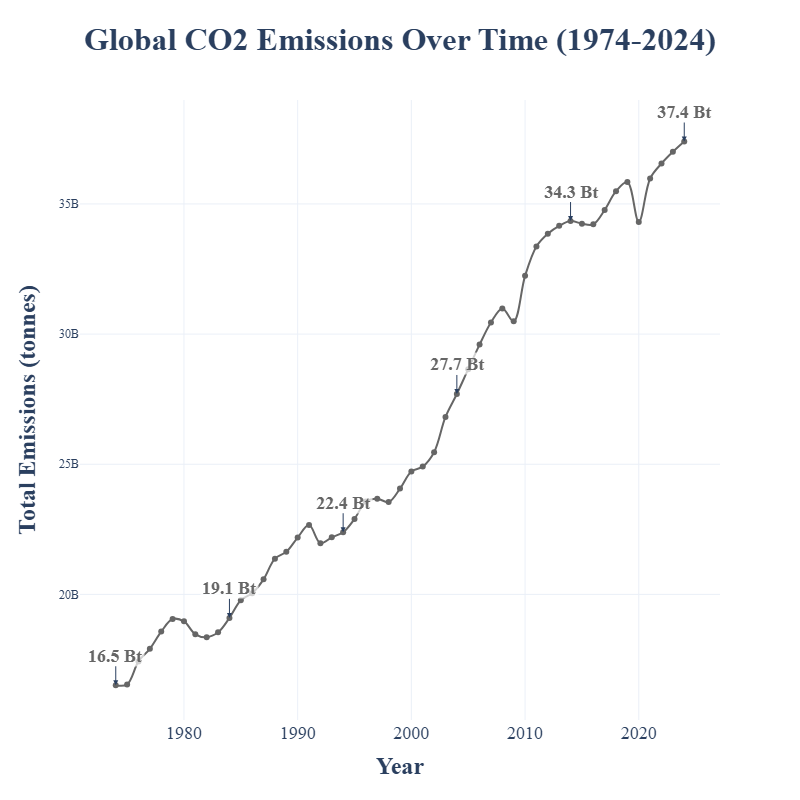

### Bar plot emissioni

In [116]:
# 1. Prepara i dati aggregati per anno e continente
emissions_all = (
    emission_raw
    .merge(world_clean, left_on="Code", right_on="code")
    .groupby(["Year", "continent"], as_index=False)
    .agg({"emissions_total": "sum"})
    .rename(columns={"continent": "Entity"})
)

# 2. Dizionario colori per continenti (2024)
continent_colors_2024 = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}

# 3. Dizionario colori per continenti (1974)
continent_colors_1974 = {
    'Asia': px.colors.qualitative.Set2[5],
    'Africa': px.colors.qualitative.Set2[6],
    'Oceania': px.colors.qualitative.Set2[0],
    'Americas': px.colors.qualitative.Set2[1],
    'Europe': px.colors.qualitative.Set2[2],
}

# 🔑 4. Calcola l’ordine dei continenti in base al 2024
order_2024 = (
    emissions_all[emissions_all["Year"] == 2024]
    .sort_values("emissions_total", ascending=False)["Entity"]
    .tolist()
)

# 5. Grafico con go.Bar
fig = go.Figure()

for year in [1974, 2024]:
    df_year = emissions_all[emissions_all["Year"] == year]
    if year == 1974:
        colors = [continent_colors_1974.get(e, "#cccccc") for e in df_year["Entity"]]
    else:
        colors = [continent_colors_2024.get(e, "#999999") for e in df_year["Entity"]]

    fig.add_trace(go.Bar(
        x=df_year["Entity"],
        y=df_year["emissions_total"],
        name=str(year),
        marker_color=colors,
        width=0.4,
        text=["<b>" + str(val) + " Bt</b>" for val in (df_year["emissions_total"] / 1e9).round(1)],
        textposition="outside",
        textfont=dict(size=18, family="Lekton", color="#000000")
    ))

fig.update_layout(
    barmode="group",
    width=800,
    height=800,
    title="<b>CO2 Emissions by Continent (1974 vs 2024)</b>",
    title_x=0.5,
    title_y=0.95,
    title_font_size=32,
    xaxis=dict(
        tickfont=dict(size=20, weight="bold"),
        categoryorder="array",       # 👉 Ordine personalizzato
        categoryarray=order_2024     # 👉 Usa l’ordine calcolato dal 2024
    ),
    yaxis=dict(showticklabels=False, showline=False, ticks=""),
    font=dict(family="Lekton"),
    template="plotly_white",
    legend=dict(title="Year", font=dict(size=16), orientation="h", yanchor="top", y=1, xanchor="center", x=0.1),
    showlegend=False
)

fig.show()


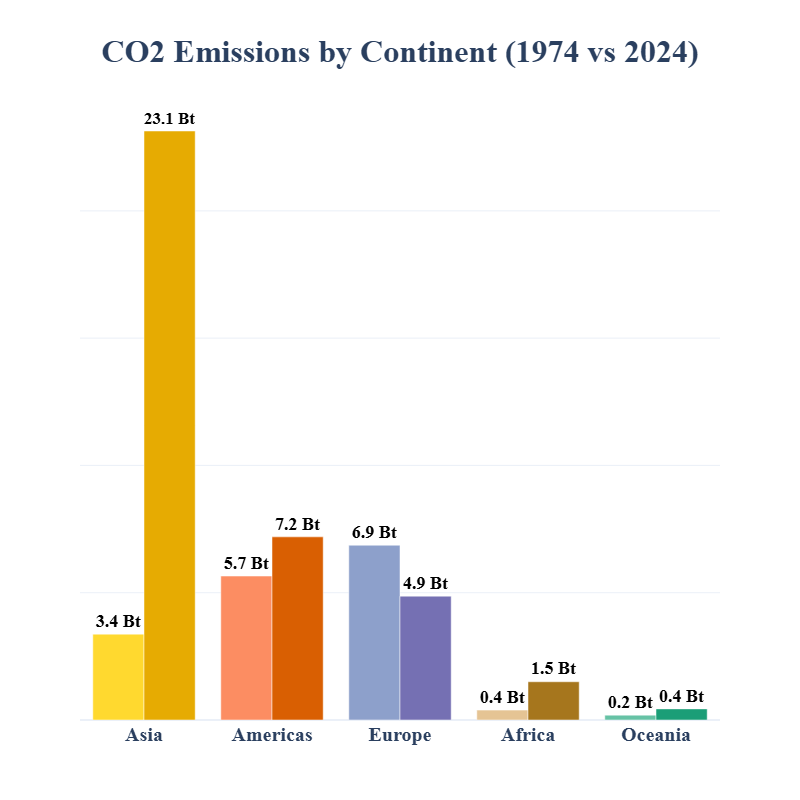

In [115]:
combined_emissions_data = sql("""
SELECT wc.continent AS Entity, SUM(er.emissions_total) AS emissions_total FROM emission_raw AS er
INNER JOIN world_clean AS wc ON er.Code = wc.code
WHERE er.Year = 1974
GROUP BY wc.continent
""")

display(combined_emissions_data)

# Pre-format the text directly in the DataFrame
combined_emissions_data['formatted_text'] = '' + (combined_emissions_data['emissions_total']/1e9).round(1).astype(str) + ' Bt'

color_map = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}


fig = px.bar(combined_emissions_data.sort_values(by='emissions_total', ascending=False), # Sort for better visualization
             x='Entity',
             y='emissions_total',
             orientation='v',
             title=' CO2 Emissions: China, US vs Other Continents (1974) ',
             text='formatted_text', # Use the pre-formatted text column
             color='Entity', # Differentiate bars by entity
             color_discrete_map=color_map
            )

# Set text font and template for all traces
fig.update_traces(texttemplate='%{text}', textfont=dict(size=24, family='Lekton', weight='bold')) # Simplified texttemplate to just display the pre-formatted text

# Adjust text position conditionally
for trace in fig.data:
    # Clean the entity name as it contains HTML bold tags from SQL query
    entity_name = trace.name.replace('', '').replace('', '')
    if entity_name == 'Oceania':
        trace.textposition = 'outside'
    else:
        trace.textposition = 'inside'

fig.update_layout(
    yaxis=dict(showticklabels=False, showline=False, ticks=''), # Hide y-axis labels, line and ticks
    xaxis=dict(tickfont=dict(size=24, weight='bold')), # Make x-axis tick labels bold and set size
    width=1200,
    height=600,
    title_x=0.5,
    title_y=0.9,
    title_font_size=32, # Larger title
    font=dict(family='Lekton'), # Set font family to Lekton
    xaxis_title_text='', # Remove x-axis title
    yaxis_title_text='', # Remove y-axis title
    showlegend=False, # Remove legend
    template='plotly_white' # Set white background
)

fig.show()

,Entity,emissions_total
0,None,3.930972e+07
1,Africa,3.880463e+08
2,Americas,5.654859e+09
3,Asia,3.372705e+09
4,Europe,6.865761e+09
5,Oceania,1.908558e+08


In [6]:
hierarchical_emissions_2024 = sql("""
SELECT
    'Asia' AS main_category,
    'China' AS sub_category,
    SUM(er.emissions_total) AS total_emissions
FROM
    emission_raw AS er
WHERE
    er.Entity = 'China' AND er.Year = 2024

UNION ALL

SELECT
    'Americas' AS main_category,
    'United States' AS sub_category,
    SUM(er.emissions_total) AS total_emissions
FROM
    emission_raw AS er
WHERE
    er.Entity = 'United States' AND er.Year = 2024

UNION ALL

SELECT
    'Asia' AS main_category,
    'Rest of Asia' AS sub_category,
    SUM(er.emissions_total) AS total_emissions
FROM
    emission_raw AS er
INNER JOIN
    world_clean AS wc ON er.Code = wc.code
WHERE
    er.Year = 2024
    AND wc.continent = 'Asia'\n    AND er.Entity != 'China'

UNION ALL

SELECT
    'Americas' AS main_category,
    'Rest of Americas' AS sub_category,
    SUM(er.emissions_total) AS total_emissions
FROM
    emission_raw AS er
INNER JOIN
    world_clean AS wc ON er.Code = wc.code
WHERE
    er.Year = 2024
    AND wc.continent = 'Americas'\n    AND er.Entity != 'United States'

UNION ALL

SELECT
    wc.continent AS main_category,
    wc.continent AS sub_category,
    SUM(er.emissions_total) AS total_emissions
FROM
    emission_raw AS er
INNER JOIN
    world_clean AS wc ON er.Code = wc.code
WHERE
    er.Year = 2024
    AND wc.continent IN ('Europe', 'Africa', 'Oceania')
GROUP BY
    wc.continent
""")

display(hierarchical_emissions_2024.head())

# Calculate total emissions for 'Asia' and 'Americas' from the original hierarchical_emissions_2024
asia_total_emissions = hierarchical_emissions_2024[hierarchical_emissions_2024['main_category'] == 'Asia']['total_emissions'].sum()
americas_total_emissions = hierarchical_emissions_2024[hierarchical_emissions_2024['main_category'] == 'Americas']['total_emissions'].sum()

sub_category_colors = {
    'China': px.colors.qualitative.Set2[5], # Asia
    'Rest of Asia': px.colors.qualitative.Dark2[5], # Lighter shade for rest of Asia
    'United States': px.colors.qualitative.Set2[1], # Americas
    'Rest of Americas': px.colors.qualitative.Dark2[1], # Lighter shade for rest of Americas
    'Europe': px.colors.qualitative.Dark2[2],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0]
}

hierarchical_emissions_2024_sorted = hierarchical_emissions_2024.sort_values(
    by=['main_category', 'sub_category'], ascending=[True, True]
)

# Pre-format the text directly in the DataFrame for bar labels with conditional sub-category name
def get_formatted_bar_text(row):
    emissions = row['total_emissions']
    if pd.isna(emissions):
        emission_value_str = '0.0'
    else:
        # Decide which value to display based on sub_category
        if row['sub_category'] == 'Rest of Asia':
            value_to_format = asia_total_emissions
        elif row['sub_category'] == 'Rest of Americas':
            value_to_format = americas_total_emissions
        else:
            value_to_format = emissions # For China, US, Europe, Africa, Oceania

        emission_value_str = str(round(value_to_format / 1e9, 1))

    # Apply conditional prefix/suffix for China/US labels
    if row['sub_category'] == 'China':
        return f"China <b>{emission_value_str} Bt</b>"
    elif row['sub_category'] == 'United States':
        return f"USA <b>{emission_value_str} Bt</b>"
    else: # For other continents (Europe, Africa, Oceania) and for the total from those continents
        return f"<b>{emission_value_str} Bt</b>"

hierarchical_emissions_2024_sorted['formatted_bar_text'] = hierarchical_emissions_2024_sorted.apply(get_formatted_bar_text, axis=1)

fig = px.bar(hierarchical_emissions_2024_sorted.sort_values(by='total_emissions', ascending=False), # Sort for better visualization
             x='main_category',
             y='total_emissions',
             color='sub_category',
             orientation='v',
             title='<b>Global CO2 Emissions by Continent and Key Countries (2024)</b>', # Updated title
             text='formatted_bar_text', # Use pre-formatted text for bar labels
             color_discrete_map=sub_category_colors
            )

# Set text font and template for all traces
fig.update_traces(texttemplate='%{text}', textfont=dict(size=24, family='Lekton', weight='bold')) # Simplified texttemplate to just display the pre-formatted text

# Adjust text position conditionally
for trace in fig.data:
    # Clean the entity name as it contains HTML bold tags from SQL query
    entity_name = trace.name.replace('<b>', '').replace('</b>', '')
    if entity_name == 'Oceania':
        trace.textposition = 'outside'
    else:
        trace.textposition = 'inside'

fig.update_layout(
    yaxis=dict(showticklabels=False, showline=False, ticks=''), # Hide y-axis labels, line and ticks
    xaxis=dict(tickfont=dict(size=24, weight='bold')), # Make x-axis tick labels bold and set size
    width=1200,
    height=600,
    title_x=0.5,
    title_y=0.9, # Adjusted for new title font size
    title_font_size=32, # Larger title
    font=dict(family='Lekton'), # Set font family to Lekton
    xaxis_title_text='', # Remove x-axis title
    yaxis_title_text='', # Remove y-axis title
    showlegend=False, # Remove legend
    template='plotly_white' # Set white background
)

fig.show()

,main_category,sub_category,total_emissions
0,Asia,China,1.228904e+10
1,Americas,United States,4.904120e+09
2,Asia,Rest of Asia,1.084841e+10
3,Americas,Rest of Americas,2.289998e+09
4,Africa,Africa,1.502099e+09


### Bar plot gdp

In [ ]:
gdp_rank = sql("""
SELECT wc.continent, SUM(gdp_raw.ny_gdp_mktp_pp_kd) as total_gdp FROM gdp_raw
INNER JOIN world_clean as wc ON gdp_raw.Code = wc.code
WHERE year = 1994 AND wc.continent IS NOT NULL
GROUP BY wc.continent
ORDER BY total_gdp DESC
""")

display(gdp_rank.head())

color_map = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}

# Pre-format the text directly in the DataFrame for bar labels
gdp_rank['formatted_text'] = '<b>' + (gdp_rank['total_gdp']/1e12).round(1).astype(str) + 'kB$</b>'

fig = px.bar(gdp_rank.sort_values(by='total_gdp', ascending=True), # Sort for better visualization
             x='total_gdp',
             y='continent',
             orientation='h',
             title='<b>Total Gdp by Continent (1994)</b>',
             text='formatted_text', # Use pre-formatted text column
             color='continent', # Differentiate bars by continent
             color_discrete_map=color_map
            )

# Set text font and template for all traces
fig.update_traces(texttemplate='%{text}', textposition='inside', textfont=dict(size=24, family='Lekton', weight='bold')) # Use pre-formatted text, set font styles

fig.update_layout(
    yaxis=dict(showticklabels=True, showline=False, ticks='', tickfont=dict(size=20, weight='bold'), categoryorder='total ascending'), # Hide y-axis line/ticks, make labels bold
    xaxis=dict(showticklabels=False, showline=False, ticks=''), # Hide x-axis labels, line and ticks
    width=800,
    height=800,
    title_x=0.5,
    title_font_size=32, # Larger title
    font=dict(family='Lekton'), # Set font family to Lekton
    xaxis_title_text='', # Remove x-axis title
    yaxis_title_text='', # Remove y-axis title
    showlegend=False, # Remove legend
    template='plotly_white' # Set white background
)

fig.show()

,continent,total_gdp
0,Europe,20975643005943
1,Americas,19454768053097
2,Asia,18221454819792
3,Africa,2834195085091
4,Oceania,813253976412


RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



In [ ]:
gdp_rank = sql("""
SELECT wc.continent, SUM(gdp_raw.ny_gdp_mktp_pp_kd) as total_gdp FROM gdp_raw
INNER JOIN world_clean as wc ON gdp_raw.Code = wc.code
WHERE year = 2024 AND wc.continent IS NOT NULL
GROUP BY wc.continent
ORDER BY total_gdp DESC
""")

display(gdp_rank.head())

color_map = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}

# Pre-format the text directly in the DataFrame for bar labels
gdp_rank['formatted_text'] = '<b>' + (gdp_rank['total_gdp']/1e12).round(1).astype(str) + 'kB$</b>'

fig = px.bar(gdp_rank.sort_values(by='total_gdp', ascending=True), # Sort for better visualization
             x='total_gdp',
             y='continent',
             orientation='h',
             title='<b>Total Gdp by Continent (2024)</b>',
             text='formatted_text', # Use pre-formatted text column
             color='continent', # Differentiate bars by continent
             color_discrete_map=color_map
            )

# Set text font and template for all traces
fig.update_traces(texttemplate='%{text}', textposition='inside', textfont=dict(size=24, family='Lekton', weight='bold')) # Use pre-formatted text, set font styles

fig.update_layout(
    yaxis=dict(showticklabels=True, showline=False, ticks='', tickfont=dict(size=20, weight='bold'), categoryorder='total ascending'), # Hide y-axis line/ticks, make labels bold
    xaxis=dict(showticklabels=False, showline=False, ticks=''), # Hide x-axis labels, line and ticks
    width=800,
    height=800,
    title_x=0.5,
    title_font_size=32, # Larger title
    font=dict(family='Lekton'), # Set font family to Lekton
    xaxis_title_text='', # Remove x-axis title
    yaxis_title_text='', # Remove y-axis title
    showlegend=False, # Remove legend
    template='plotly_white' # Set white background
)

fig.show()

,continent,total_gdp
0,Asia,79632359687725
1,Americas,40363454686801
2,Europe,36632699429940
3,Africa,8882380441060
4,Oceania,1956127949171


RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



### Treemap (backup visualization)

In [ ]:
emission_treemap_1974 = sql("""
SELECT wc.continent, SUM(emissions_total) AS total_emissions_per_continent FROM emission_raw
INNER JOIN world_clean as wc ON emission_raw.Code = wc.code
WHERE year = 1974 AND wc.continent IS NOT NULL
GROUP BY wc.continent
ORDER BY total_emissions_per_continent DESC
""")

display(emission_treemap_1974)

emission_treemap_2024 = sql("""
SELECT wc.continent, SUM(emissions_total) AS total_emissions_per_continent FROM emission_raw
INNER JOIN world_clean as wc ON emission_raw.Code = wc.code
WHERE year = 2024 AND wc.continent IS NOT NULL
GROUP BY wc.continent
ORDER BY total_emissions_per_continent DESC
""")

display(emission_treemap_2024)

,continent,total_emissions_per_continent
0,Europe,6.865761e+09
1,Americas,5.654859e+09
2,Asia,3.372705e+09
3,Africa,3.880463e+08
4,Oceania,1.908558e+08


,continent,total_emissions_per_continent
0,Asia,2.313744e+10
1,Americas,7.194118e+09
2,Europe,4.865165e+09
3,Africa,1.502099e+09
4,Oceania,4.368966e+08


In [ ]:
color_map = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}

# Create a new column combining region name and total emissions for display
emission_treemap_1974['region_label_with_emissions'] = emission_treemap_1974['continent'] + '<br>' + emission_treemap_1974['total_emissions_per_continent'].apply(lambda x: f'{x/1e9:.1f} Bt')

fig = px.treemap(emission_treemap_1974, path=['region_label_with_emissions'], # Use the new combined label
                 values='total_emissions_per_continent',
                 color='continent',
                 title='<b>CO2 emissions by continent (1974)<b>',
                 color_discrete_map=color_map
                 )

fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25),
    width=800, height=800,
    title_x=0.5,
    title_y=0.95,
    title_font_size=32,
    font=dict(family='Lekton'), # Apply Lekton font
    title_font_color=px.colors.qualitative.Dark2[7] # Set title color
)

fig.update_traces(
    texttemplate='<b>%{label}</b>',
    textfont_color='white',
    textfont_size=20,
    textposition='middle center'
)

fig.show()

NameError: name 'emission_treemap_1974' is not defined

In [ ]:
color_map = {
    'Asia': px.colors.qualitative.Dark2[5],
    'Africa': px.colors.qualitative.Dark2[6],
    'Oceania': px.colors.qualitative.Dark2[0],
    'Americas': px.colors.qualitative.Dark2[1],
    'Europe': px.colors.qualitative.Dark2[2],
}

# Create a new column combining region name and total emissions for display
emission_treemap_2024['region_label_with_emissions'] = emission_treemap_2024['continent'] + '<br>' + emission_treemap_2024['total_emissions_per_continent'].apply(lambda x: f'{x/1e9:.1f} Bt')

fig = px.treemap(emission_treemap_2024, path=['region_label_with_emissions'], # Use the new combined label
                 values='total_emissions_per_continent',
                 color='continent',
                 title='<b> CO2 emissions by continent (2024)<b>',
                 color_discrete_map=color_map
                 )

fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25),
    width=800, height=800,
    title_x=0.5,
    title_y=0.95,
    title_font_size=32,
    font=dict(family='Lekton'), # Apply Lekton font
    title_font_color=px.colors.qualitative.Dark2[7] # Set title color
)

fig.update_traces(
    texttemplate='<b>%{label}</b>',
    textfont_color='white',
    textfont_size=20,
    textposition='middle center'
)

fig.show()

NameError: name 'emission_treemap_2024' is not defined

## 2. Introduzione - Il quadro europeo e italiano

- Classifica migliori nazioni per rinnovabili
- choropleth principale fonte rinnovabile
- sunburst europa vs italia

In [ ]:
fossil_columns = ['gas', 'oil', 'coal']
renew_cols = ['wind', 'hydro', 'other_renewables', 'solar', 'biofuels', 'nuclear']
renew_cols_no_nuclear = ['wind', 'hydro', 'other_renewables', 'solar', 'biofuels']

new_columns = {}
for col in share_raw.columns:
    if '__pct_direct_primary_energy' in col:
        new_name = col.replace('__pct_direct_primary_energy', '')
        new_columns[col] = new_name
share_raw = share_raw.rename(columns=new_columns)

share_rank = sql(f"""
SELECT wc.country, wc.sub_region, {"+".join(renew_cols_no_nuclear)} as renewable_sources FROM share_raw
INNER JOIN world_clean as wc ON share_raw.Code = wc.code
WHERE Year = 2024 AND wc.continent = 'Europe'
ORDER BY renewable_sources DESC
LIMIT 10
""")

display(share_rank)

,country,sub_region,renewable_sources
0,Iceland,Northern Europe,61.079995
1,Norway,Northern Europe,51.531187
2,Sweden,Northern Europe,36.580810
3,Finland,Northern Europe,25.822603
4,Switzerland,Western Europe,24.933096
5,Austria,Western Europe,24.336303
6,Denmark,Northern Europe,22.578787
7,Portugal,Southern Europe,21.866678
8,Latvia,Northern Europe,14.612510
9,Slovenia,Southern Europe,14.300901


In [ ]:
# Get unique sub_regions and create a color map with shades of blue
unique_sub_regions = sorted(share_rank['sub_region'].unique().tolist())
blue_shades = px.colors.sequential.Aggrnyl # Get sequential blues palette

# Create a mapping for sub_regions to blue shades, ensuring enough shades are available
sub_region_color_map = {}
# Assign shades, starting from a slightly darker one for better contrast
for i, region in enumerate(unique_sub_regions):
    sub_region_color_map[region] = blue_shades[min(i + 3, len(blue_shades) - 1)] # Ensure index is within bounds

# Sort the DataFrame for better visualization (countries with more renewables at the top)
plot_data = share_rank.sort_values(by='renewable_sources', ascending=True)

fig = px.bar(plot_data,
             x='renewable_sources',
             y='country',
             color='sub_region',
             orientation='h',
             title='<b> Top 10 Europe for renewable energy share (2024)</b>',
             text='renewable_sources', # Value to display on the bar
             color_discrete_map=sub_region_color_map # Apply the custom blue color map
            )

# Update traces for text formatting
fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside', textfont=dict(size=14, family='Lekton', weight='bold'))

# Update layout for overall aesthetics
fig.update_layout(
    title_x=0.5, # Center the title
    title_font_size=32, # Larger title
    xaxis=dict(title_text='', showticklabels=False, showgrid=False, zeroline=False), # Remove x-axis title, hide labels, grid, and zeroline
    yaxis=dict(title_text='', showticklabels=True, tickfont=dict(size=20, weight='bold'), categoryorder='total ascending', showgrid=False, showline=False), # Remove y-axis title, make labels bold, hide grid and line
    width=800,
    height=800, # Increased height to ensure all country names are visible
    font=dict(family='Lekton'), # Set global font family
    showlegend=True,
    legend=dict(
        orientation="h", # Horizontal legend
        yanchor="bottom",
        y=-0.2, # Position legend below the plot area (adjust as needed)
        xanchor="center",
        x=0,
        title_text='<b>Sub-Region</b>',
        font=dict(size=18)
    ),
    legend_font_size=18,
    legend_title_font_size=20,
    template='plotly_white' # Set white background
)

fig.show()

NameError: name 'share_rank' is not defined

In [ ]:
share_rank = sql(f"""
SELECT wc.country, wc.sub_region, {"+".join(fossil_columns)} as renewable_sources FROM share_raw
INNER JOIN world_clean as wc ON share_raw.Code = wc.code
WHERE Year = 2024 AND wc.continent = 'Europe'
ORDER BY renewable_sources DESC
LIMIT 10
""")


# Rename 'Netherlands, Kingdom of the' to 'Netherland'
share_rank['country'] = share_rank['country'].replace('Netherlands, Kingdom of the', 'Netherland')

In [ ]:
# Get unique sub_regions and create a color map with shades of blue
unique_sub_regions = sorted(share_rank['sub_region'].unique().tolist())
blue_shades = px.colors.sequential.Brwnyl # Get sequential blues palette

# Create a mapping for sub_regions to blue shades, ensuring enough shades are available
sub_region_color_map = {}
# Assign shades, starting from a slightly darker one for better contrast
for i, region in enumerate(unique_sub_regions):
    sub_region_color_map[region] = blue_shades[min(i + 3, len(blue_shades) - 1)] # Ensure index is within bounds

# Sort the DataFrame for better visualization (countries with more renewables at the top)
plot_data = share_rank.sort_values(by='renewable_sources', ascending=True)

fig = px.bar(plot_data,
             x='renewable_sources',
             y='country',
             color='sub_region',
             orientation='h',
             title='<b> Top 10 Europe for renewable energy share (2024)</b>',
             text='renewable_sources', # Value to display on the bar
             color_discrete_map=sub_region_color_map # Apply the custom blue color map
            )

# Update traces for text formatting
fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside', textfont=dict(size=14, family='Lekton', weight='bold'))

# Update layout for overall aesthetics
fig.update_layout(
    title_x=0.5, # Center the title
    title_font_size=32, # Larger title
    xaxis=dict(title_text='', showticklabels=False, showgrid=False, zeroline=False), # Remove x-axis title, hide labels, grid, and zeroline
    yaxis=dict(title_text='', showticklabels=True, tickfont=dict(size=20, weight='bold'), categoryorder='total ascending', showgrid=False, showline=False), # Remove y-axis title, make labels bold, hide grid and line
    width=800,
    height=800, # Increased height to ensure all country names are visible
    font=dict(family='Lekton'), # Set global font family
    showlegend=True,
    legend=dict(
        orientation="h", # Horizontal legend
        yanchor="bottom",
        y=-0.2, # Position legend below the plot area (adjust as needed)
        xanchor="center",
        x=0,
        title_text='<b>Sub-Region</b>',
        font=dict(size=18)
    ),
    legend_font_size=18,
    legend_title_font_size=20,
    template='plotly_white' # Set white background
)

fig.show()

NameError: name 'share_rank' is not defined

In [ ]:
sunburst_mix = sql(f"""
SELECT wc.country, {",".join(fossil_columns)}, {",".join(renew_cols_no_nuclear)} FROM share_raw
INNER JOIN world_clean as wc ON share_raw.Code = wc.code
WHERE Year = 2024 AND wc.continent = 'Europe'
""")

display(sunburst_mix.head())

,country,gas,oil,coal,wind,hydro,other_renewables,solar,biofuels
0,Austria,22.632970,43.752766,9.277962,3.055430,14.861383,1.541471,3.126327,1.751691
1,Belarus,58.215400,32.091440,3.866252,0.059731,0.093311,0.176509,0.051812,0.000000
2,Belgium,23.862420,58.838610,5.511098,2.371115,0.095255,0.583786,1.545744,1.573844
3,Bulgaria,18.176176,40.994648,21.195766,0.922531,1.927641,1.153046,3.631812,1.441292
4,Croatia,27.951710,55.583473,3.128219,3.166354,7.996201,1.196350,0.966420,0.011271


In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# 1. Get data for European countries in 2024
europe_2024_share_df = sql("""
SELECT sr.gas, sr.oil, sr.coal, sr.nuclear, sr.wind, sr.hydro, sr.other_renewables, sr.solar, sr.biofuels FROM share_raw AS sr
INNER JOIN world_clean AS wc ON sr.Code = wc.code
WHERE sr.Year = 2024 AND wc.code = 'ITA'
""")

# Calculate the average share for each source across European countries
numeric_cols = ['gas', 'oil', 'coal', 'nuclear', 'wind', 'hydro', 'other_renewables', 'solar', 'biofuels']
europe_avg_share = europe_2024_share_df[numeric_cols].mean().to_dict()

# Define categories (Nuclear included in Non-Renewables as it's not renewable)
renew_sources = ['wind', 'hydro', 'other_renewables', 'solar', 'biofuels', 'nuclear']
non_renew_sources = ['gas', 'oil', 'coal']

# 2. Prepare data for the sunburst chart
sunburst_data_list = []

# Root node
sunburst_data_list.append(dict(
    id="Total",
    labels="<b>European Energy Mix<b>",
    parents="",
    source_type="Total",
    value=sum(europe_avg_share[s] for s in renew_sources + non_renew_sources if s in europe_avg_share)
))

# Level 1: Renewables
total_renew_val = sum(europe_avg_share[s] for s in renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Renewables",
    labels="Renewables",
    parents="Total",
    source_type="Renewables",
    value=total_renew_val
))
# Level 2: Individual Renewable Sources
for source in renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Renewables",
            source_type="Renewable Source",
            value=europe_avg_share[source]
        ))

# Level 1: Non-Renewables
total_non_renew_val = sum(europe_avg_share[s] for s in non_renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Non-Renewables",
    labels="Non-Renewables",
    parents="Total",
    source_type="Non-Renewables",
    value=total_non_renew_val
))
# Level 2: Individual Non-Renewable Sources
for source in non_renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Non-Renewables",
            source_type="Non-Renewable Source",
            value=europe_avg_share[source]
        ))

sunburst_df = pd.DataFrame(sunburst_data_list)

# Ensure values are numeric
sunburst_df['value'] = pd.to_numeric(sunburst_df['value'])


energy_source_color_map = {
    'hydro': px.colors.qualitative.Light24[13],
    'nuclear': px.colors.qualitative.Light24[10],
    'wind': px.colors.qualitative.Light24[5],
    'solar': px.colors.qualitative.Light24[6],
    'other_renewables': px.colors.qualitative.Light24[19],
    'biofuels': px.colors.qualitative.Light24[7],

    'gas': px.colors.qualitative.Antique[9],
    'oil': px.colors.qualitative.Antique[3],
    'coal': px.colors.qualitative.Antique[10],

    'Total': 'white', # Grey for the total
    'Renewables': px.colors.qualitative.Dark24[10], # A distinct color for the Renewables slice
    'Non-Renewables': px.colors.qualitative.Antique[10], # A distinct color for the Non-Renewables slice
}

# 3. Create the sunburst chart
fig = px.sunburst(sunburst_df,
                  ids='id',
                  names='labels',
                  parents='parents',
                  values='value',
                  title='<b>European Energy Mix (2024) </b>',
                  color='id', # Color based on the 'id' column for specific colors
                  color_discrete_map=energy_source_color_map,
                  branchvalues='total'
                 )

# 4. Apply aesthetic enhancements (similar to previous charts)
fig.update_layout(
    title_x=0.5,
    title_y=0.95, # Adjust title_y to move title higher
    width=800,
    height=800, # Increased height to ensure all country names are visible
    title_font_size=32, # Adjusted to match previous plots
    font=dict(family='Lekton', size=14),
    margin = dict(t=100, l=25, r=25, b=25),
    hovermode='closest'
)

fig.update_traces(
    textinfo='label+percent parent', # Show label and percentage relative to parent
    insidetextfont=dict(family='Lekton', size=14), # Lekton font for inside text
    hovertemplate='<b>%{label}</b><br>Share: %{value:.1f}%<br><i>(%{percentParent:.1%}) of %{parent}</i>' # Custom hover text
)

fig.show()

RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# 1. Get data for European countries in 2024
europe_2024_share_df = sql("""
SELECT sr.gas, sr.oil, sr.coal, sr.nuclear, sr.wind, sr.hydro, sr.other_renewables, sr.solar, sr.biofuels FROM share_raw AS sr
INNER JOIN world_clean AS wc ON sr.Code = wc.code
WHERE sr.Year = 2024 AND wc.sub_region = 'Northern Europe'
""")

# Calculate the average share for each source across European countries
numeric_cols = ['gas', 'oil', 'coal', 'nuclear', 'wind', 'hydro', 'other_renewables', 'solar', 'biofuels']
europe_avg_share = europe_2024_share_df[numeric_cols].mean().to_dict()

# Define categories (Nuclear included in Non-Renewables as it's not renewable)
renew_sources = ['wind', 'hydro', 'other_renewables', 'solar', 'biofuels', 'nuclear']
non_renew_sources = ['gas', 'oil', 'coal']

# 2. Prepare data for the sunburst chart
sunburst_data_list = []

# Root node
sunburst_data_list.append(dict(
    id="Total",
    labels="<b>European Energy Mix<b>",
    parents="",
    source_type="Total",
    value=sum(europe_avg_share[s] for s in renew_sources + non_renew_sources if s in europe_avg_share)
))

# Level 1: Renewables
total_renew_val = sum(europe_avg_share[s] for s in renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Renewables",
    labels="Renewables",
    parents="Total",
    source_type="Renewables",
    value=total_renew_val
))
# Level 2: Individual Renewable Sources
for source in renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Renewables",
            source_type="Renewable Source",
            value=europe_avg_share[source]
        ))

# Level 1: Non-Renewables
total_non_renew_val = sum(europe_avg_share[s] for s in non_renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Non-Renewables",
    labels="Non-Renewables",
    parents="Total",
    source_type="Non-Renewables",
    value=total_non_renew_val
))
# Level 2: Individual Non-Renewable Sources
for source in non_renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Non-Renewables",
            source_type="Non-Renewable Source",
            value=europe_avg_share[source]
        ))

sunburst_df = pd.DataFrame(sunburst_data_list)

# Ensure values are numeric
sunburst_df['value'] = pd.to_numeric(sunburst_df['value'])


energy_source_color_map = {
    'hydro': px.colors.qualitative.Light24[13],
    'nuclear': px.colors.qualitative.Light24[10],
    'wind': px.colors.qualitative.Light24[5],
    'solar': px.colors.qualitative.Light24[6],
    'other_renewables': px.colors.qualitative.Light24[19],
    'biofuels': px.colors.qualitative.Light24[7],

    'gas': px.colors.qualitative.Antique[9],
    'oil': px.colors.qualitative.Antique[3],
    'coal': px.colors.qualitative.Antique[10],

    'Total': 'white', # Grey for the total
    'Renewables': px.colors.qualitative.Dark24[10], # A distinct color for the Renewables slice
    'Non-Renewables': px.colors.qualitative.Antique[10], # A distinct color for the Non-Renewables slice
}

# 3. Create the sunburst chart
fig = px.sunburst(sunburst_df,
                  ids='id',
                  names='labels',
                  parents='parents',
                  values='value',
                  title='<b>Northern Energy Mix (2024) </b>',
                  color='id', # Color based on the 'id' column for specific colors
                  color_discrete_map=energy_source_color_map,
                  branchvalues='total'
                 )

# 4. Apply aesthetic enhancements (similar to previous charts)
fig.update_layout(
    title_x=0.5,
    title_y=0.95, # Adjust title_y to move title higher
    width=800,
    height=800, # Increased height to ensure all country names are visible
    title_font_size=32, # Adjusted to match previous plots
    font=dict(family='Lekton', size=14),
    margin = dict(t=100, l=25, r=25, b=25),
    hovermode='closest'
)

fig.update_traces(
    textinfo='label+percent parent', # Show label and percentage relative to parent
    insidetextfont=dict(family='Lekton', size=14), # Lekton font for inside text
    hovertemplate='<b>%{label}</b><br>Share: %{value:.1f}%<br><i>(%{percentParent:.1%}) of %{parent}</i>' # Custom hover text
)

fig.show()

RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



In [13]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# 1. Get data for European countries in 2024
europe_2024_share_df = sql("""
SELECT sr.gas, sr.oil, sr.coal, sr.nuclear, sr.wind, sr.hydro, sr.other_renewables, sr.solar, sr.biofuels FROM share_raw AS sr
INNER JOIN world_clean AS wc ON sr.Code = wc.code
WHERE sr.Year = 2024 AND wc.sub_region = 'Southern Europe'
""")

# Calculate the average share for each source across European countries
numeric_cols = ['gas', 'oil', 'coal', 'nuclear', 'wind', 'hydro', 'other_renewables', 'solar', 'biofuels']
europe_avg_share = europe_2024_share_df[numeric_cols].mean().to_dict()

# Define categories (Nuclear included in Non-Renewables as it's not renewable)
renew_sources = ['wind', 'hydro', 'other_renewables', 'solar', 'biofuels', 'nuclear']
non_renew_sources = ['gas', 'oil', 'coal']

# 2. Prepare data for the sunburst chart
sunburst_data_list = []

# Root node
sunburst_data_list.append(dict(
    id="Total",
    labels="<b>European Energy Mix<b>",
    parents="",
    source_type="Total",
    value=sum(europe_avg_share[s] for s in renew_sources + non_renew_sources if s in europe_avg_share)
))

# Level 1: Renewables
total_renew_val = sum(europe_avg_share[s] for s in renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Renewables",
    labels="Renewables",
    parents="Total",
    source_type="Renewables",
    value=total_renew_val
))
# Level 2: Individual Renewable Sources
for source in renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Renewables",
            source_type="Renewable Source",
            value=europe_avg_share[source]
        ))

# Level 1: Non-Renewables
total_non_renew_val = sum(europe_avg_share[s] for s in non_renew_sources if s in europe_avg_share)
sunburst_data_list.append(dict(
    id="Non-Renewables",
    labels="Non-Renewables",
    parents="Total",
    source_type="Non-Renewables",
    value=total_non_renew_val
))
# Level 2: Individual Non-Renewable Sources
for source in non_renew_sources:
    if source in europe_avg_share and europe_avg_share[source] > 0:
        sunburst_data_list.append(dict(
            id=source,
            labels=source.replace('_', ' ').title(),
            parents="Non-Renewables",
            source_type="Non-Renewable Source",
            value=europe_avg_share[source]
        ))

sunburst_df = pd.DataFrame(sunburst_data_list)

# Ensure values are numeric
sunburst_df['value'] = pd.to_numeric(sunburst_df['value'])


energy_source_color_map = {
    'hydro': px.colors.qualitative.Light24[13],
    'nuclear': px.colors.qualitative.Light24[10],
    'wind': px.colors.qualitative.Light24[5],
    'solar': px.colors.qualitative.Light24[6],
    'other_renewables': px.colors.qualitative.Light24[19],
    'biofuels': px.colors.qualitative.Light24[7],

    'gas': px.colors.qualitative.Antique[9],
    'oil': px.colors.qualitative.Antique[3],
    'coal': px.colors.qualitative.Antique[10],

    'Total': 'white', # Grey for the total
    'Renewables': px.colors.qualitative.Dark24[10], # A distinct color for the Renewables slice
    'Non-Renewables': px.colors.qualitative.Antique[10], # A distinct color for the Non-Renewables slice
}

# 3. Create the sunburst chart
fig = px.sunburst(sunburst_df,
                  ids='id',
                  names='labels',
                  parents='parents',
                  values='value',
                  title='<b>Southern Energy Mix (2024) </b>',
                  color='id', # Color based on the 'id' column for specific colors
                  color_discrete_map=energy_source_color_map,
                  branchvalues='total'
                 )

# 4. Apply aesthetic enhancements (similar to previous charts)
fig.update_layout(
    title_x=0.5,
    title_y=0.95, # Adjust title_y to move title higher
    width=800,
    height=800, # Increased height to ensure all country names are visible
    title_font_size=32, # Adjusted to match previous plots
    font=dict(family='Lekton', size=14),
    margin = dict(t=100, l=25, r=25, b=25),
    hovermode='closest'
)

fig.update_traces(
    textinfo='label+percent parent', # Show label and percentage relative to parent
    insidetextfont=dict(family='Lekton', size=14), # Lekton font for inside text
    hovertemplate='<b>%{label}</b><br>Share: %{value:.1f}%<br><i>(%{percentParent:.1%}) of %{parent}</i>' # Custom hover text
)

fig.show()